#  Regularized MLR (OLS / Ridge / Lasso / ElasticNet) 

#### Imports — core utils, data wrangling, ML, and stats

In [1]:
# Data handling
import numpy as np
import pandas as pd
from IPython.display import display

# Core + utils
from math import sqrt
import re

# ML (scikit-learn)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Stats (statsmodels)
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Parallel
from joblib import Parallel, delayed, dump

import os
# To prevent BLAS oversubscription; we parallelize at sklearn/joblib level
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Parallelism knob
N_JOBS = -1  # Use all available cores

#### Data paths, loading, and preparation

In [2]:
# Paths (aligned with earlier prep)
SAVE_DIR   = 'Data+Files+Plots+etc'
TRAIN_CSV  = f'{SAVE_DIR}/train.csv'
TEST_CSV   = f'{SAVE_DIR}/test.csv'
FOLDS_NPY  = f'{SAVE_DIR}/train_folds.npy'

# Load splits
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
fold_assignments = np.load(FOLDS_NPY)

# Feature/target setup (physics-consistent)
raw_feats  = ['distance','frequency','c_walls','w_walls', 'co2','humidity','pm25','pressure','temperature','snr']
target_col = 'PL'

# Train/test matrices
Xtr_raw = df_train[raw_feats].copy()
ytr_pl  = df_train[target_col].astype(float).values
Xte_raw = df_test[raw_feats].copy()
yte_pl  = df_test[target_col].astype(float).values

def slug(obj):
    """Filename-safe tag for model/config (kept readable)."""
    if isinstance(obj, dict) and obj:
        items = []
        for k in sorted(obj.keys()):
            v = obj[k]
            if isinstance(v, (float, np.floating)): v = float(v)
            items.append(f"{k}={v}")
        s = "__".join(items)
    else:
        s = str(obj) if obj not in (None, {}, []) else ""
    return re.sub(r"[^A-Za-z0-9._=-]+", "_", s).strip("_")

# Required columns check 
required_cols = ['PL', 'device_id', 'distance','frequency','c_walls','w_walls', 'co2','humidity','pm25','pressure','temperature','snr']
missing = [c for c in required_cols if c not in df_train.columns or c not in df_test.columns]
if missing:
    raise ValueError(f"Missing required columns in train/test: {missing}")

#### Physics-consistent linearization + helpers + model specs

In [3]:
# Linearize (Friis-adjusted): y_adj = PL - 20*log10(f)
d0 = 1.0
def z_of_d(d): 
    return 10.0*np.log10(np.clip(d.astype(float), 1e-6, None)/d0)
def f_term(f):
    return 20.0*np.log10(np.clip(f.astype(float), 1e-12, None))

# Adjusted targets
ftr_tr, ftr_te = f_term(Xtr_raw['frequency'].values), f_term(Xte_raw['frequency'].values)
ytr_adj, yte_adj = ytr_pl - ftr_tr, yte_pl - ftr_te

# Linear feature maps
cols = ['z_d','c_walls','w_walls','co2','humidity','pm25','pressure','temperature','snr']
Xtr_lin = pd.DataFrame({
    'z_d': z_of_d(Xtr_raw['distance'].values),
    'c_walls': Xtr_raw['c_walls'].values,
    'w_walls': Xtr_raw['w_walls'].values,
    'co2': Xtr_raw['co2'].values,
    'humidity': Xtr_raw['humidity'].values,
    'pm25': Xtr_raw['pm25'].values,
    'pressure': Xtr_raw['pressure'].values,
    'temperature': Xtr_raw['temperature'].values,
    'snr': Xtr_raw['snr'].values
}, columns=cols).values

Xte_lin = pd.DataFrame({
    'z_d': z_of_d(Xte_raw['distance'].values),
    'c_walls': Xte_raw['c_walls'].values,
    'w_walls': Xte_raw['w_walls'].values,
    'co2': Xte_raw['co2'].values,
    'humidity': Xte_raw['humidity'].values,
    'pm25': Xte_raw['pm25'].values,
    'pressure': Xte_raw['pressure'].values,
    'temperature': Xte_raw['temperature'].values,
    'snr': Xte_raw['snr'].values
}, columns=cols).values

# Param labels (for reporting)
param_names = [
    'PL(d0) [dB]', 'Path loss exponent (n)',
    'Brick Wall Loss (L_c) [dB]', 'Wood Wall Loss (L_w) [dB]',
    'CO2 coef. [dB/unit]', 'Humidity coef. [dB/%]',
    'PM2.5 coef. [dB/µg/m³]', 'Pressure coef. [dB/hPa]',
    'Temp. coef. [dB/°C]', 'SNR scaling (k_snr)'
]

# Helpers
def unscale_coefficients(pipeline):
    """Undo StandardScaler effect → coeffs in original units."""
    steps = pipeline.named_steps
    est = steps.get('ridge') or steps.get('lasso') or steps.get('elasticnet') or steps.get('linearregression')
    if 'standardscaler' not in steps:
        return float(est.intercept_), est.coef_.astype(float).copy()
    scaler = steps['standardscaler']
    beta_scaled = est.coef_.astype(float)
    mu, sig = scaler.mean_, scaler.scale_
    beta_orig = beta_scaled / sig
    intercept_orig = float(est.intercept_ - np.sum(beta_scaled * mu / sig))
    return intercept_orig, beta_orig

def fold_indices(folds, k):
    val_idx = np.where(folds == k)[0]
    tr_idx  = np.where(folds != k)[0]
    return tr_idx, val_idx

def rmse_r2_on_PL(y_true_pl, y_pred_adj, fterm):
    """Score in PL-domain (add back freq term)."""
    y_pred_pl = y_pred_adj + fterm
    rmse = sqrt(mean_squared_error(y_true_pl, y_pred_pl))
    r2   = r2_score(y_true_pl, y_pred_pl)
    return rmse, r2

# Model factories
def make_OLS(_): return make_pipeline(LinearRegression())
def make_Ridge(cfg): return make_pipeline(StandardScaler(), Ridge(alpha=cfg["alpha"], random_state=42))
def make_Lasso(cfg): return make_pipeline(StandardScaler(), Lasso(alpha=cfg["alpha"], max_iter=20000, random_state=42))
def make_ElasticNet(cfg): return make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=cfg["alpha"], l1_ratio=cfg["l1_ratio"], max_iter=20000, random_state=42)
)

# Grids
ridge_grid = [dict(alpha=a) for a in np.logspace(-4, 3, 15)]
lasso_grid = [dict(alpha=a) for a in np.logspace(-4, 1, 15)]
enet_grid  = [dict(alpha=a, l1_ratio=r) for a in np.logspace(-4, 1, 10) for r in (0.2, 0.5, 0.8)]

# Spec list
specs = [
    ("OLS",        make_OLS,        [dict()]),
    ("Ridge",      make_Ridge,      ridge_grid),
    ("Lasso",      make_Lasso,      lasso_grid),
    ("ElasticNet", make_ElasticNet, enet_grid),
]

#### Time-aware K-fold CV on the train split to pick the best config per MLR variant, then refit on full train subset

In [4]:
# K-fold CV over each MLR model
results = []
K = int(np.max(fold_assignments)) + 1

# Precompute indices once (saves a bit)
folds = [fold_indices(fold_assignments, k) for k in range(K)]

print(f"Running CV for  {len(specs)} MLR variants | K={len(folds)} folds | grid eval={'parallel...' if (N_JOBS != 1) else 'sequential...'}")

residuals_list = []  # collect per-model test residual DataFrames for saving

def eval_cfg(factory, cfg, folds):
    tr_rmse_list, val_rmse_list, tr_r2_list, val_r2_list = [], [], [], []
    for tr_idx, val_idx in folds:
        X_tr, X_val = Xtr_lin[tr_idx], Xtr_lin[val_idx]
        y_tr, y_val = ytr_adj[tr_idx], ytr_adj[val_idx]
        ypl_tr, ypl_val = ytr_pl[tr_idx], ytr_pl[val_idx]
        f_tr,  f_val  = ftr_tr[tr_idx],  ftr_tr[val_idx]

        pipe = factory(cfg)
        pipe.fit(X_tr, y_tr)

        y_tr_pred_adj = pipe.predict(X_tr)
        rmse_tr, r2_tr = rmse_r2_on_PL(ypl_tr, y_tr_pred_adj, f_tr)
        tr_rmse_list.append(rmse_tr); tr_r2_list.append(r2_tr)

        y_val_pred_adj = pipe.predict(X_val)
        rmse_val, r2_val = rmse_r2_on_PL(ypl_val, y_val_pred_adj, f_val)
        val_rmse_list.append(rmse_val); val_r2_list.append(r2_val)

    return {
        "cfg": cfg,
        "rmse_train_mean": float(np.mean(tr_rmse_list)), "rmse_train_sd": float(np.std(tr_rmse_list)),
        "rmse_val_mean":   float(np.mean(val_rmse_list)), "rmse_val_sd":   float(np.std(val_rmse_list)),
        "r2_train_mean":   float(np.mean(tr_r2_list)),    "r2_train_sd":    float(np.std(tr_r2_list)),
        "r2_val_mean":     float(np.mean(val_r2_list)),   "r2_val_sd":      float(np.std(val_r2_list)),
    }

for name, factory, grid in specs:
    if len(grid) == 1:  # OLS: no sweep
        grid_results = [eval_cfg(factory, grid[0], folds)]
    else:
        # Parallelize across configs; BLAS is single-threaded (from header), so this scales well.
        grid_results = Parallel(n_jobs=N_JOBS, backend="threading", prefer="threads", verbose=0)(
            delayed(eval_cfg)(factory, cfg, folds) for cfg in grid
        )

    best_res = min(grid_results, key=lambda r: r["rmse_val_mean"])
    best_cfg, best_cv = best_res["cfg"], {k: v for k, v in best_res.items() if k != "cfg"}

    # Refit on all training data with best hyperparams
    final_pipe = factory(best_cfg)
    final_pipe.fit(Xtr_lin, ytr_adj)

    # Test metrics (PL domain)
    yte_pred_adj = final_pipe.predict(Xte_lin)
    test_rmse, test_r2 = rmse_r2_on_PL(yte_pl, yte_pred_adj, ftr_te)

    # Build residuals on the 20% test split (uniform schema)
    PL_pred  = yte_pred_adj + ftr_te
    resid_db = yte_pl - PL_pred
    tag_cfg  = slug(best_cfg)
    model_tag = f"MLR_{name}" if tag_cfg == "" else f"MLR_{name}__{tag_cfg}"

    # Coefficients back in original units
    intercept_orig, beta_orig = unscale_coefficients(final_pipe)
    coeffs = np.concatenate(([intercept_orig], beta_orig))
    coeffs_series = pd.Series(coeffs, index=param_names, name=name)

    results.append({
        "model":       name,
        "best_cfg":    best_cfg,
        "cv":          best_cv,
        "test":        {"rmse": float(test_rmse), "r2": float(test_r2)},
        "coeffs":      coeffs_series,
        "final_pipe":  final_pipe,   # keep the fitted pipeline
        "model_tag":   model_tag     # tag used for filenames
    })

print("\nDone processing!")

Running CV for  4 MLR variants | K=5 folds | grid eval=parallel...

Done processing!


#### MLR CV summary (mean ± sd across folds), best model highlighted, then OOF residuals for BEST are saved.

In [5]:
# Best MLR by mean CV Val RMSE 
best_overall  = min(results, key=lambda r: r["cv"]["rmse_val_mean"])
best_name     = best_overall["model"]      # OLS / Ridge / Lasso / ElasticNet
best_cfg      = best_overall["best_cfg"]
best_long_tag = best_overall["model_tag"]

def mlr_short_tag(name: str) -> str:
    return f"MLR_{name}"

best_tag_short = mlr_short_tag(best_name)

# CV-only summary table (TRAIN split only)
rows = []
for r in results:
    cfg = r.get("best_cfg", {}) if isinstance(r.get("best_cfg", {}), dict) else {"cfg": str(r.get("best_cfg"))}
    rows.append({
        "model":            mlr_short_tag(r["model"]),
        "is_best":          (r["model_tag"] == best_long_tag),
        "cv_rmse_val_mean": r["cv"]["rmse_val_mean"],
        "cv_rmse_val_sd":   r["cv"]["rmse_val_sd"],
        "cv_r2_val_mean":   r["cv"]["r2_val_mean"],
        "alpha":            cfg.get("alpha", np.nan),
        "l1_ratio":         cfg.get("l1_ratio", np.nan),
    })

mlr_cv_table = (pd.DataFrame(rows)
                .sort_values(["cv_rmse_val_mean", "cv_rmse_val_sd", "model"])
                .reset_index(drop=True))

display(mlr_cv_table)

# BEST residuals on TEST (refit on full TRAIN already stored in best_overall["final_pipe"])
best_pipe = best_overall["final_pipe"]
yte_pred_adj = best_pipe.predict(Xte_lin)

PL_pred_test = yte_pred_adj + ftr_te
resid_test   = yte_pl - PL_pred_test

mlr_test_df = pd.DataFrame({
    "model":       "MLR_BEST",
    "split":       "test",
    "row_id":      np.arange(len(df_test), dtype=int),
    "time":        df_test.get("time", pd.Series(index=df_test.index, dtype=float)).values,
    "device_id":   df_test["device_id"].values,
    "distance":    df_test["distance"].values,
    "frequency":   df_test["frequency"].values,
    "c_walls":     df_test["c_walls"].values,
    "w_walls":     df_test["w_walls"].values,
    "co2":         df_test["co2"].values,
    "humidity":    df_test["humidity"].values,
    "pm25":        df_test["pm25"].values,
    "pressure":    df_test["pressure"].values,
    "temperature": df_test["temperature"].values,
    "snr":         df_test["snr"].values,
    "PL_true":     yte_pl,
    "PL_pred":     PL_pred_test,
    "resid_db":    resid_test
})

test_path = f"{SAVE_DIR}/residuals__MLR__BEST__test.csv"
mlr_test_df.to_csv(test_path, index=False)
print(f"\n[TEST] Saved best MLR test residuals: {test_path}")

# OOF residuals for BEST (train-only)
factory_for_best = next(f for (n, f, g) in specs if n == best_name)

y_pred_adj_oof = np.full(len(ytr_adj), np.nan, dtype=float)
for tr_idx, val_idx in folds:
    pipe = factory_for_best(best_cfg)
    pipe.fit(Xtr_lin[tr_idx], ytr_adj[tr_idx])
    y_pred_adj_oof[val_idx] = pipe.predict(Xtr_lin[val_idx])

mask = ~np.isnan(y_pred_adj_oof)

PL_pred_oof = y_pred_adj_oof[mask] + ftr_tr[mask]
resid_oof   = ytr_pl[mask] - PL_pred_oof

mlr_oof_df = pd.DataFrame({
    "model":       "MLR_BEST",
    "split":       "oof",
    "row_id":      np.arange(len(df_train), dtype=int)[mask],
    "fold":        fold_assignments.astype(int)[mask],
    "time":        df_train.get("time", pd.Series(index=df_train.index, dtype=float)).values[mask],
    "device_id":   df_train["device_id"].values[mask],
    "distance":    df_train["distance"].values[mask],
    "frequency":   df_train["frequency"].values[mask],
    "c_walls":     df_train["c_walls"].values[mask],
    "w_walls":     df_train["w_walls"].values[mask],
    "co2":         df_train["co2"].values[mask],
    "humidity":    df_train["humidity"].values[mask],
    "pm25":        df_train["pm25"].values[mask],
    "pressure":    df_train["pressure"].values[mask],
    "temperature": df_train["temperature"].values[mask],
    "snr":         df_train["snr"].values[mask],
    "PL_true":     ytr_pl[mask],
    "PL_pred":     PL_pred_oof,
    "resid_db":    resid_oof
})

oof_path = f"{SAVE_DIR}/residuals__MLR__BEST__oof.csv"
mlr_oof_df.to_csv(oof_path, index=False)
print(f"\n[OOF] Saved best MLR OOF residuals: {oof_path}")

,model,is_best,cv_rmse_val_mean,cv_rmse_val_sd,cv_r2_val_mean,alpha,l1_ratio
0,MLR_ElasticNet,True,8.233291,0.557738,0.806084,0.059948,0.5
1,MLR_Ridge,False,8.240977,0.581891,0.805566,1000.000000,NaN
2,MLR_OLS,False,8.241577,0.582735,0.805532,NaN,NaN
3,MLR_Lasso,False,8.241578,0.582740,0.805532,0.000100,NaN



[TEST] Saved best MLR test residuals: Data+Files+Plots+etc/residuals__MLR__BEST__test.csv

[OOF] Saved best MLR OOF residuals: Data+Files+Plots+etc/residuals__MLR__BEST__oof.csv


#### Predictive ablation aligned with ANOVA blocks (OLS; only predictor set changes)

In [6]:
col_i = {c: i for i, c in enumerate(cols)}  # cols already defined earlier

# (label, columns to include, pretty display label)
ABL = [
    ("Structure-only",
     ["z_d", "c_walls", "w_walls"],
     "z_d, 𝐰"),
    ("+ Environment (planning)",
     ["z_d", "c_walls", "w_walls", "co2", "humidity", "pm25", "pressure", "temperature"],
     "z_d, 𝐰, 𝐞"),
    ("+ SNR (full)",
     ["z_d", "c_walls", "w_walls", "co2", "humidity", "pm25", "pressure", "temperature", "snr"],
     "z_d, 𝐰, 𝐞, γ"),
]

def ablation_metrics(use_cols):
    idx = np.array([col_i[c] for c in use_cols], dtype=int)

    rmse_folds, r2_folds = [], []
    for tr_idx, val_idx in folds:
        m = LinearRegression().fit(Xtr_lin[tr_idx][:, idx], ytr_adj[tr_idx])
        yhat_adj = m.predict(Xtr_lin[val_idx][:, idx])
        rmse, r2 = rmse_r2_on_PL(ytr_pl[val_idx], yhat_adj, ftr_tr[val_idx])
        rmse_folds.append(rmse)
        r2_folds.append(r2)

    m_full = LinearRegression().fit(Xtr_lin[:, idx], ytr_adj)
    yhat_te_adj = m_full.predict(Xte_lin[:, idx])
    rmse_te, r2_te = rmse_r2_on_PL(yte_pl, yhat_te_adj, ftr_te)

    return (float(np.mean(rmse_folds)),
            float(np.std(rmse_folds)),
            float(np.mean(r2_folds)),
            float(rmse_te),
            float(r2_te))

rows = []
for name, use_cols, disp_terms in ABL:
    cv_rmse, cv_rmse_sd, cv_r2, te_rmse, te_r2 = ablation_metrics(use_cols)
    rows.append({
        "Predictor set": name,
        "Included terms": disp_terms,
        "RMSE (OOF)": f"{cv_rmse:.4f} ± {cv_rmse_sd:.4f}",
        "RMSE (Test)": f"{te_rmse:.4f}",
        "R2 (OOF)": f"{cv_r2:.4f}",
        "R2 (Test)": f"{te_r2:.4f}",
    })

ablation_df = pd.DataFrame(rows)
display(ablation_df)

,Predictor set,Included terms,RMSE (OOF),RMSE (Test),R2 (OOF),R2 (Test)
0,Structure-only,"z_d, 𝐰",10.9739 ± 1.0518,12.0704,0.6533,0.5890
1,+ Environment (planning),"z_d, 𝐰, 𝐞",10.9313 ± 1.0504,12.0956,0.6563,0.5873
2,+ SNR (full),"z_d, 𝐰, 𝐞, γ",8.2416 ± 0.5827,8.4534,0.8055,0.7984


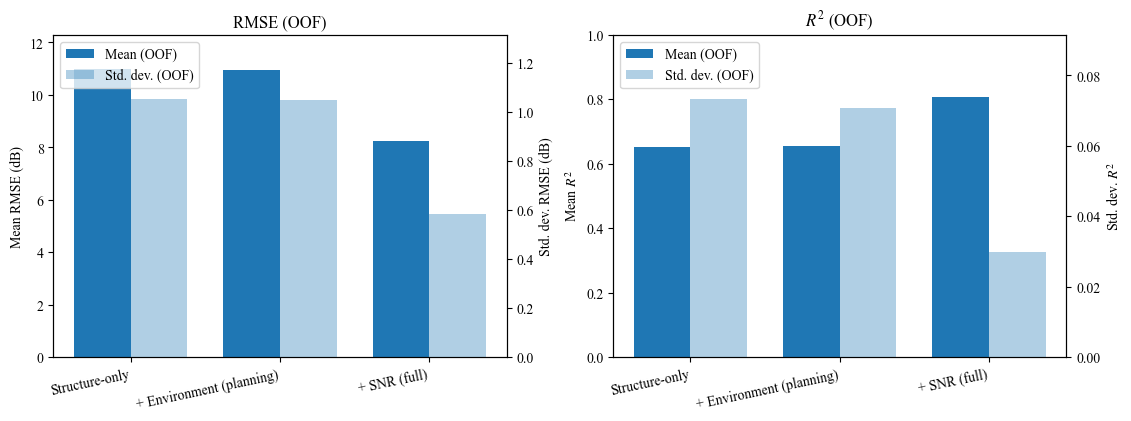

In [7]:
# --- 1×2 bar plots (RMSE | R²): LEFT y-axis = mean (OOF), RIGHT y-axis = std. dev. (OOF) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

labels = [t[0] for t in ABL]      # works whether ABL entries are 2- or 3-tuples
x = np.arange(len(labels))
w = 0.38

def oof_mean_sd(use_cols):
    idx = np.array([col_i[c] for c in use_cols], dtype=int)
    rmse_f, r2_f = [], []
    for tr_idx, val_idx in folds:
        m = LinearRegression().fit(Xtr_lin[tr_idx][:, idx], ytr_adj[tr_idx])
        yhat_adj = m.predict(Xtr_lin[val_idx][:, idx])
        rmse, r2 = rmse_r2_on_PL(ytr_pl[val_idx], yhat_adj, ftr_tr[val_idx])
        rmse_f.append(rmse); r2_f.append(r2)
    return (float(np.mean(rmse_f)), float(np.std(rmse_f)),
            float(np.mean(r2_f)),   float(np.std(r2_f)))

rmse_mu, rmse_sd, r2_mu, r2_sd = [], [], [], []
for t in ABL:
    mu_rmse, sd_rmse, mu_r2, sd_r2 = oof_mean_sd(t[1])
    rmse_mu.append(mu_rmse); rmse_sd.append(sd_rmse)
    r2_mu.append(mu_r2);     r2_sd.append(sd_r2)

def dual_axis_bars(ax, mu, sd, title, ylab_mu, ylab_sd, mu_ylim=None, sd_ylim=None):
    ax_sd = ax.twinx()  # RIGHT axis for std

    ax.bar(x - w/2, mu, w, label="Mean (OOF)")
    ax_sd.bar(x + w/2, sd, w, alpha=0.35, label="Std. dev. (OOF)")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=12, ha="right")
    ax.set_ylabel(ylab_mu)
    ax_sd.set_ylabel(ylab_sd)
    ax.set_title(title)

    if mu_ylim is not None: ax.set_ylim(*mu_ylim)
    if sd_ylim is not None: ax_sd.set_ylim(*sd_ylim)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax_sd.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="upper left", frameon=True)

fig, axs = plt.subplots(1, 2, figsize=(11.2, 4.1), constrained_layout=True)

dual_axis_bars(
    axs[0], rmse_mu, rmse_sd,
    "RMSE (OOF)", "Mean RMSE (dB)", "Std. dev. RMSE (dB)",
    mu_ylim=(0, max(rmse_mu)*1.12),
    sd_ylim=(0, max(rmse_sd)*1.25 if max(rmse_sd) > 0 else 0.01),
)

dual_axis_bars(
    axs[1], r2_mu, r2_sd,
    r"$R^2$ (OOF)", r"Mean $R^2$", r"Std. dev. $R^2$",
    mu_ylim=(0, 1.0),
    sd_ylim=(0, max(r2_sd)*1.25 if max(r2_sd) > 0 else 0.01),
)

plt.show()

#### Final held-out evaluation on the 20% test split for the CV-selected model

In [8]:
# Final test evaluation (held-out 20%): selected model only
test_rows = []
for res in results:
    te = res["test"]
    test_rows.append({
        "Model": res["model"],
        "Test RMSE": float(te["rmse"]),
        "Test R2":   float(te["r2"]),
    })

# Frame + display
test_df = pd.DataFrame(test_rows)
display(test_df)

,Model,Test RMSE,Test R2
0,OLS,8.453447,0.798423
1,Ridge,8.454240,0.798385
2,Lasso,8.453403,0.798425
3,ElasticNet,8.484460,0.796941


#### Coefficient table (all models, final fits, original units)

In [9]:
# Collect coeffs side by side
coef_df = pd.concat([res['coeffs'] for res in results], axis=1)
coef_df.columns = [res['model'] for res in results]

print("\n Harmonized Coefficients (final all-train fits, original units) ")
display(coef_df)


 Harmonized Coefficients (final all-train fits, original units) 


,OLS,Ridge,Lasso,ElasticNet
PL(d0) [dB],2.305528,2.359624,2.298639,2.454082
Path loss exponent (n),3.866506,3.860131,3.866596,3.623919
Brick Wall Loss (L_c) [dB],6.830244,6.833462,6.829939,6.841285
Wood Wall Loss (L_w) [dB],1.977092,1.984641,1.976906,2.221589
CO2 coef. [dB/unit],-0.002355,-0.002361,-0.002354,-0.002453
Humidity coef. [dB/%],-0.091712,-0.091503,-0.091687,-0.074745
PM2.5 coef. [dB/µg/m³],-0.095295,-0.094584,-0.095261,-0.056054
Pressure coef. [dB/hPa],-0.008045,-0.008044,-0.008033,-0.004172
Temp. coef. [dB/°C],-0.141028,-0.141187,-0.140993,-0.137472
SNR scaling (k_snr),-2.034426,-2.033469,-2.034403,-1.980566


##  ANOVA for MLR (physics form)

#### OLS analysis frames + formulas (PL adj by Friis; linear predictors)

In [10]:
# Build analysis DataFrame (PL_adj + linear drivers)
dfA = pd.DataFrame({
    "PL_adj":       df_train[target_col].astype(float).values - f_term(df_train["frequency"].values),
    "z_d":          z_of_d(df_train["distance"].values),
    "c_walls":      df_train["c_walls"].values,
    "w_walls":      df_train["w_walls"].values,
    "co2":          df_train["co2"].values,
    "humidity":     df_train["humidity"].values,
    "pm25":         df_train["pm25"].values,
    "pressure":     df_train["pressure"].values,
    "temperature":  df_train["temperature"].values,
    "snr":          df_train["snr"].values,
})

# Formulas
full_terms        = "z_d + c_walls + w_walls + co2 + humidity + pm25 + pressure + temperature + snr"
formula_full      = f"PL_adj ~ {full_terms}"
struct_terms      = "z_d + c_walls + w_walls"
formula_struct    = f"PL_adj ~ {struct_terms}"
env_terms         = "co2 + humidity + pm25 + pressure + temperature"
formula_structenv = f"PL_adj ~ {struct_terms} + {env_terms}"

# Fit OLS (HC3 robust SEs)
model_full   = smf.ols(formula=formula_full,      data=dfA).fit(cov_type="HC3")
model_struct = smf.ols(formula=formula_struct,    data=dfA).fit(cov_type="HC3")
model_env    = smf.ols(formula=formula_structenv, data=dfA).fit(cov_type="HC3")

#### ANOVA (Type II, HC3 robust)

In [11]:
# Run Type-II ANOVA (HC3)
anova_type2 = anova_lm(model_full, typ=2, robust="hc3")

print("\n Type-II ANOVA (HC3 robust) — additive linear model ")
display(anova_type2)


 Type-II ANOVA (HC3 robust) — additive linear model 


,sum_sq,df,F,PR(>F)
z_d,2.841734e+07,1.0,439732.635513,0.000000e+00
c_walls,2.055390e+07,1.0,318053.019786,0.000000e+00
w_walls,3.582198e+06,1.0,55431.274920,0.000000e+00
co2,1.189826e+05,1.0,1841.147620,0.000000e+00
humidity,5.004296e+05,1.0,7743.696561,0.000000e+00
pm25,6.628960e+04,1.0,1025.771742,5.263386e-225
pressure,8.164763e+03,1.0,126.342335,2.593955e-29
temperature,4.671654e+05,1.0,7228.962793,0.000000e+00
snr,1.526648e+07,1.0,236234.976583,0.000000e+00
Residual,1.075098e+08,1663617.0,NaN,NaN


#### ANOVA (Type III, HC3 robust)

In [12]:
# Run Type-III ANOVA (HC3)
anova_type3 = anova_lm(model_full, typ=3, robust="hc3")

print("\n Type-III ANOVA (HC3 robust) — additive linear model ")
display(anova_type3)


 Type-III ANOVA (HC3 robust) — additive linear model 


,sum_sq,df,F,PR(>F)
Intercept,5.209749e+03,1.0,80.616160,2.743831e-19
z_d,2.841734e+07,1.0,439732.635513,0.000000e+00
c_walls,2.055390e+07,1.0,318053.019786,0.000000e+00
w_walls,3.582198e+06,1.0,55431.274920,0.000000e+00
co2,1.189826e+05,1.0,1841.147620,0.000000e+00
humidity,5.004296e+05,1.0,7743.696561,0.000000e+00
pm25,6.628960e+04,1.0,1025.771742,5.263386e-225
pressure,8.164763e+03,1.0,126.342335,2.593955e-29
temperature,4.671654e+05,1.0,7228.962793,0.000000e+00
snr,1.526648e+07,1.0,236234.976583,0.000000e+00


#### Nested partial-F tests (RSS-based, classical)

In [ ]:
# Refit non-robust (needed for compare_f_test → uses RSS/df)
model_full_nr   = smf.ols(formula=formula_full,      data=dfA).fit()
model_struct_nr = smf.ols(formula=formula_struct,    data=dfA).fit()
model_env_nr    = smf.ols(formula=formula_structenv, data=dfA).fit()

# (A) struct → +env   (this is what the label says)
F_A, p_A, _ = model_env_nr.compare_f_test(model_struct_nr)
df_num_A = model_env_nr.df_model - model_struct_nr.df_model   
df_den_A = model_env_nr.df_resid                             
partial_eta2_A = (F_A * df_num_A) / (F_A * df_num_A + df_den_A)

# (B) +env → +snr     (already correct)
F_B, p_B, _ = model_full_nr.compare_f_test(model_env_nr)
df_num_B = model_full_nr.df_model - model_env_nr.df_model     
df_den_B = model_full_nr.df_resid                             
partial_eta2_B = (F_B * df_num_B) / (F_B * df_num_B + df_den_B)

print("\n Nested block tests (partial-F on RSS) \n")
print(f"(A) Struct → +Env:  F = {F_A:.4f}, df = ({int(df_num_A)}, {int(df_den_A)}), "
      f"p = {p_A:.3e}, partial η² = {partial_eta2_A:.4f}")
print(f"(B) +Env   → +SNR:  F = {F_B:.4f}, df = ({int(df_num_B)}, {int(df_den_B)}), "
      f"p = {p_B:.3e}, partial η² = {partial_eta2_B:.4f}")


 Nested block tests (partial-F on RSS) 

(A) Struct → +Env:  F = 3298.8856, df = (5, 1663618), p = 0.000e+00, partial η² = 0.0098
(B) +Env   → +SNR:  F = 1258588.2501, df = (1, 1663617), p = 0.000e+00, partial η² = 0.4307


#### HC3 coefficient table (interpretable params)

In [14]:
# Extract HC3-robust coefficients + CIs
coef_tbl = model_full.get_robustcov_results(cov_type="HC3").summary2().tables[1].copy()
coef_tbl.rename(columns={
    "Coef.": "coef",
    "Std.Err.": "std_err",
    "P>|t|": "pval",
    "[0.025": "ci_low",
    "0.975]": "ci_high"
}, inplace=True)

print("\n Coefficients (HC3 robust) — key parameters ")
display(coef_tbl.loc[['Intercept','z_d','c_walls','w_walls',
                      'co2','humidity','pm25','pressure','temperature','snr']])


 Coefficients (HC3 robust) — key parameters 


,coef,std_err,z,P>|z|,ci_low,ci_high
Intercept,2.305528,0.256779,8.978650,2.741087e-19,1.802250,2.808805
z_d,3.866506,0.005831,663.123394,0.000000e+00,3.855078,3.877934
c_walls,6.830244,0.012111,563.961896,0.000000e+00,6.806506,6.853981
w_walls,1.977092,0.008397,235.438474,0.000000e+00,1.960633,1.993551
co2,-0.002355,0.000055,-42.908596,0.000000e+00,-0.002463,-0.002248
humidity,-0.091712,0.001042,-87.998276,0.000000e+00,-0.093755,-0.089669
pm25,-0.095295,0.002975,-32.027671,4.492507e-225,-0.101126,-0.089463
pressure,-0.008045,0.000716,-11.240211,2.587642e-29,-0.009448,-0.006643
temperature,-0.141028,0.001659,-85.023307,0.000000e+00,-0.144279,-0.137777
snr,-2.034426,0.004186,-486.040098,0.000000e+00,-2.042630,-2.026222
